# Load Everything Here

In [1]:
!pip install -U node2vec

Requirement already up-to-date: node2vec in /usr/local/lib/python3.7/dist-packages (0.4.3)


In [2]:
!pip install -U networkx

Requirement already up-to-date: networkx in /usr/local/lib/python3.7/dist-packages (2.5.1)


In [3]:
import pandas as pd
import numpy as np
import networkx as nx
from node2vec import Node2Vec
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Read Data

In [75]:
df = pd.read_csv("Edgelist2020_2.csv")

In [76]:
df

,Source,Target,Weight
0,e1122,e6601,0.1273
1,e1122,e7800,0.1195
2,e1122,e785,0.2042
3,e1122,e8770,0.0730
4,e1122,i120,0.2158
...,...,...,...
30100,t2026xa,t2024xa,0.4846
30101,t2027xa,t20211a,0.4361
30102,t22231a,t22232a,0.5137
30103,s92324a,s92334a,0.8462


# Convert to Graph and Visualize

### graph conversion & info

In [77]:
%%time
graph=nx.convert_matrix.from_pandas_edgelist(df,source='Source', target='Target', edge_attr=None)
graph.name = "Covid DisNet for Edgelist2019_2"
print(nx.info(graph))
print("------------------------------------")

Name: Covid DisNet for Edgelist2019_2
Type: Graph
Number of nodes: 2101
Number of edges: 30105
Average degree:  28.6578
------------------------------------
CPU times: user 65.1 ms, sys: 0 ns, total: 65.1 ms
Wall time: 68.1 ms


In [78]:
degree_centrality = nx.algorithms.centrality.degree_centrality(graph)
first10pairs = {k: degree_centrality[k] for k in sorted(degree_centrality.keys())[:10]}
first10pairs

{'a0472': 0.029523809523809525,
 'a0839': 0.0009523809523809524,
 'a403': 0.0004761904761904762,
 'a4101': 0.0014285714285714286,
 'a4102': 0.0009523809523809524,
 'a414': 0.0004761904761904762,
 'a4151': 0.007142857142857143,
 'a4152': 0.0004761904761904762,
 'a4159': 0.002857142857142857,
 'a4189': 0.047142857142857146}

In [79]:
eigenvector_centrality = nx.algorithms.centrality.eigenvector_centrality_numpy(graph)
first10pairs = {k: eigenvector_centrality[k] for k in sorted(eigenvector_centrality.keys())[:10]}
first10pairs

{'a0472': 0.028865883398139978,
 'a0839': 0.0009338308525216134,
 'a403': -1.910580976727113e-18,
 'a4101': 0.0003981326292866526,
 'a4102': 1.0572806113661003e-05,
 'a414': 0.00016837607865647814,
 'a4151': 0.005496076889414611,
 'a4152': 1.1188211825370778e-05,
 'a4159': 0.0015348730393305993,
 'a4189': 0.039779899864510776}

In [80]:
katz_centrality = nx.algorithms.centrality.katz_centrality_numpy(graph)
first10pairs = {k: katz_centrality[k] for k in sorted(katz_centrality.keys())[:10]}
first10pairs

{'a0472': -0.05597927468417884,
 'a0839': 0.012955270247768406,
 'a403': 0.0016005343887325531,
 'a4101': 0.001194441681456632,
 'a4102': 0.003237604975812472,
 'a414': -0.004157446518558565,
 'a4151': 0.019922031952683765,
 'a4152': 0.003398487389935315,
 'a4159': -0.00495440684006463,
 'a4189': 0.05672733739024446}

In [81]:
number_of_triangles = sum(nx.triangles(graph).values()) / 3
number_of_triangles

842044.0

In [82]:
nx.algorithms.cluster.transitivity(graph)

0.4906473059509728

In [83]:
print(nx.average_clustering(graph))

0.478484940043083


### whole graph plot

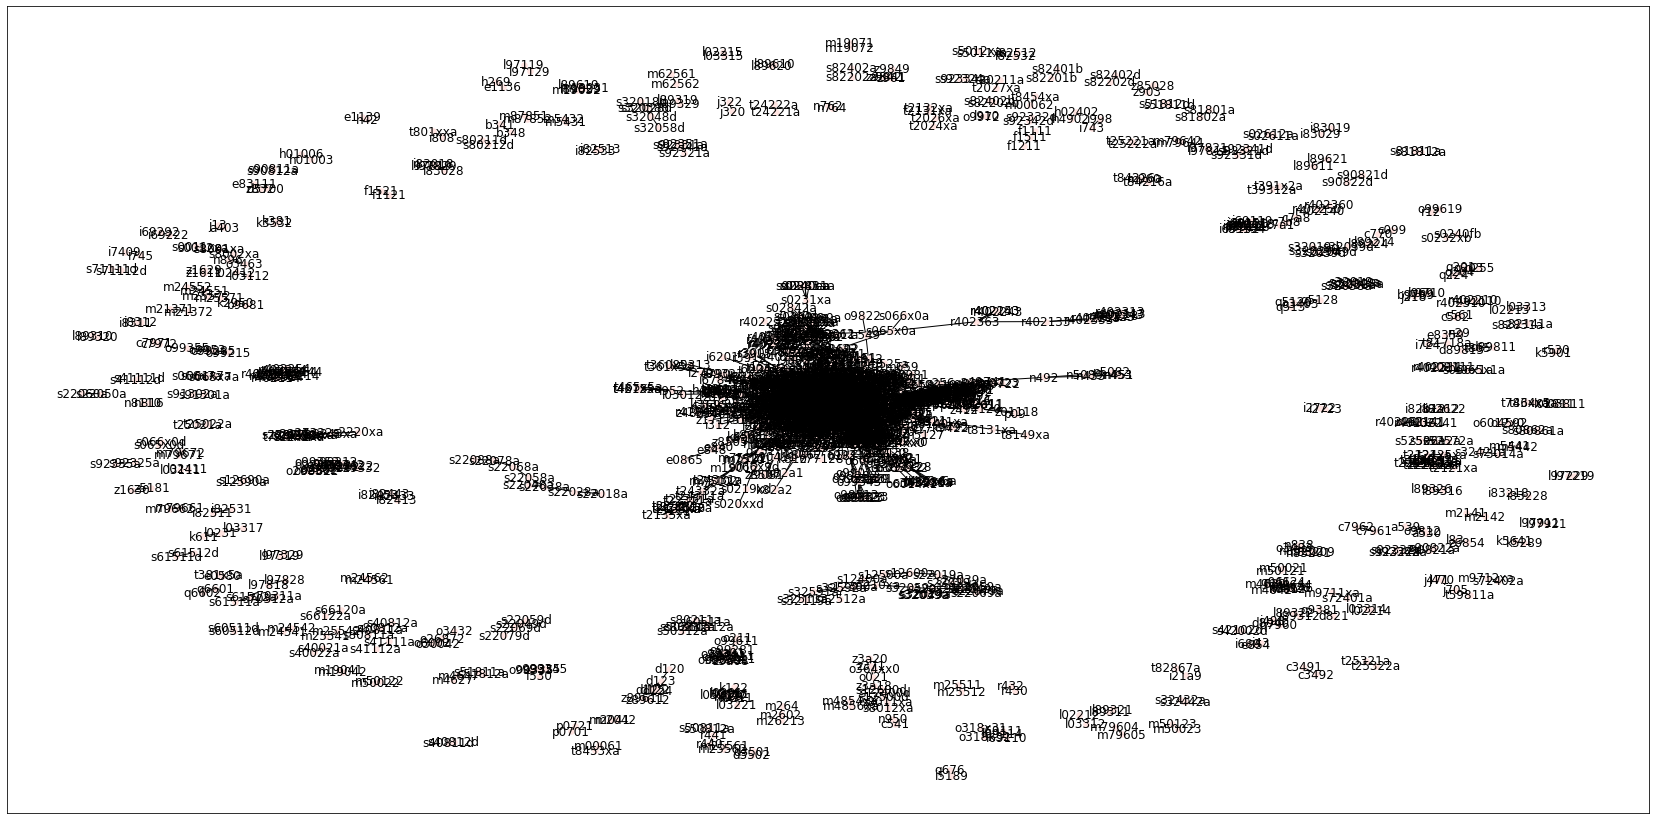

----------------------------------------
Density: 0.013646562861222547
----------------------------------------
CPU times: user 29.7 s, sys: 551 ms, total: 30.2 s
Wall time: 30 s


In [84]:
%%time
nx.draw_networkx(graph,
                 #pos,
                 with_labels=True,
                 node_size=30,
                 node_color="mistyrose",
                 #edgelist=edges, 
                 #edge_color=weights,
                 edge_cmap=plt.cm.Accent,
                 style="solid",
                 width=1)
nx.draw_networkx(graph.subgraph('z20828'),  font_size=16,node_size=120, node_color='red')
plt.subplots_adjust(left=1, bottom=3.2, right=4.8, top=6)
plt.show()

print("----------------------------------------")
print("Density:",nx.classes.function.density(graph))
print("----------------------------------------")

### partial graph plot

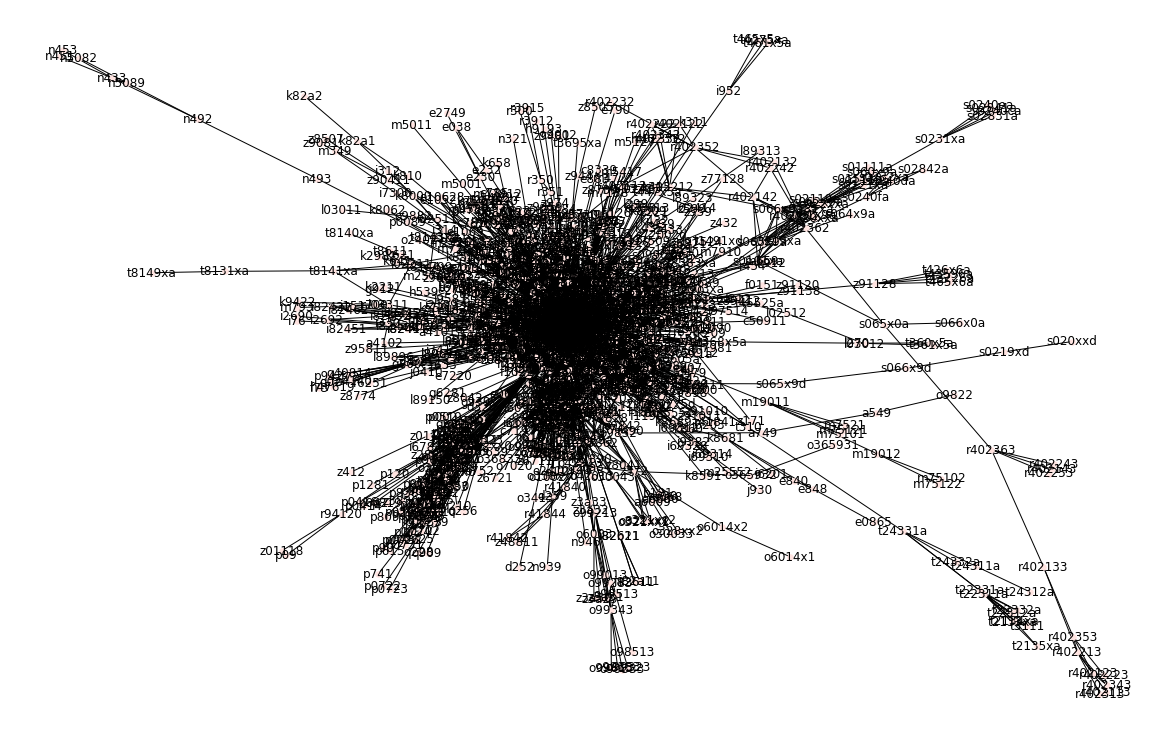

Density: 0.025556448085121437
----------------------------------------
CPU times: user 19.9 s, sys: 376 ms, total: 20.3 s
Wall time: 20.4 s


In [85]:
%%time
plt.figure(figsize=(16, 10))
gcc = max(nx.connected_components(graph), key=lambda x: len(x))
H = graph.subgraph(gcc)
nx.draw(H, node_size=30, node_color='mistyrose',with_labels=True,edge_cmap=plt.cm.Accent,style="solid",width=1)
plt.subplots_adjust(left=1, bottom=3.2, right=4.8, top=6)
plt.show()
print("Density:",nx.classes.function.density(H))
print("----------------------------------------")

### plot for z20828's neighbors

----------------------------------------
Density: 0.18554306773879142
----------------------------------------
CPU times: user 4.82 s, sys: 133 ms, total: 4.95 s
Wall time: 4.88 s


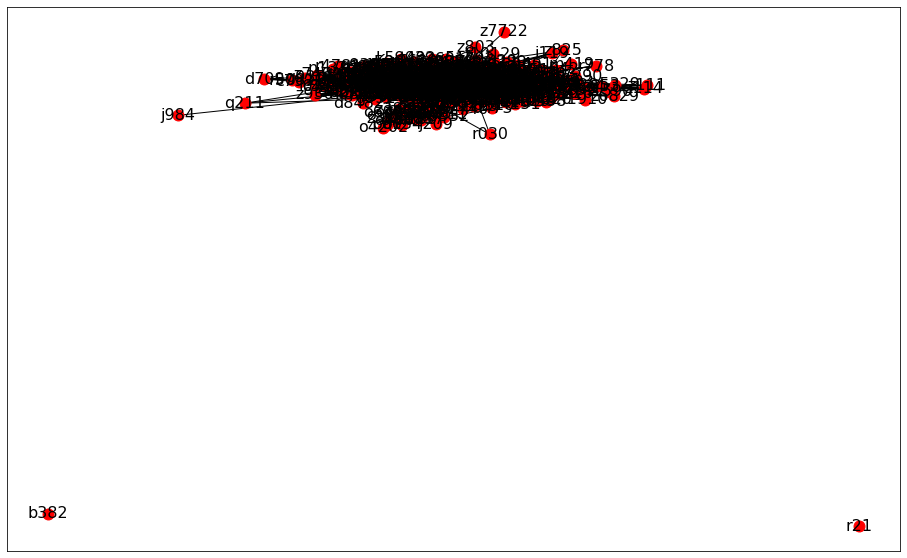

In [86]:
%%time
plt.figure(figsize=(16, 10))
Sub = nx.classes.function.induced_subgraph(graph,set(graph.neighbors(n="z20828")))
nx.draw_networkx(Sub,  font_size=16,node_size=120, node_color='red')
print("----------------------------------------")
print("Density:",nx.classes.function.density(Sub))
print("----------------------------------------")

# Fit node2vec

In [87]:
vector_size = round(df.shape[0]**0.25)
vector_size

13

In [88]:
%%time
setup = Node2Vec(graph,dimensions=vector_size, walk_length=5, num_walks=5)
model = setup.fit(window=10, min_count=1)
print("--------------------------------------")

Generating walks (CPU: 1):   0%|          | 0/5 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


--------------------------------------
CPU times: user 51.6 s, sys: 576 ms, total: 52.1 s
Wall time: 52.8 s


In [89]:
%%time
#vocab, vectors = model.wv.key_to_index, model.wv.get_normed_vectors()
vocab, vectors = model.wv.vocab, model.wv.vectors

# get node name and embedding vector index.
name_index = np.array([(v[0], v[1].index) for v in vocab.items()]) #.index

# init dataframe using embedding vectors and set index as node name
node2vec_output = pd.DataFrame(vectors[name_index[:,1].astype(int)])
node2vec_output.index = name_index[:,0]

CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 23.3 ms


In [90]:
node2vec_output.shape

(2101, 13)

In [91]:
model.wv.most_similar("z20828",topn=10)

[('f419', 0.9946932196617126),
 ('d649', 0.9946731925010681),
 ('f329', 0.9936752319335938),
 ('e6601', 0.9925082921981812),
 ('k219', 0.991245448589325),
 ('j45909', 0.9903380274772644),
 ('z8619', 0.9902105331420898),
 ('d62', 0.9889881014823914),
 ('z79890', 0.9886508584022522),
 ('f17210', 0.9886504411697388)]

# K-means

## Find k

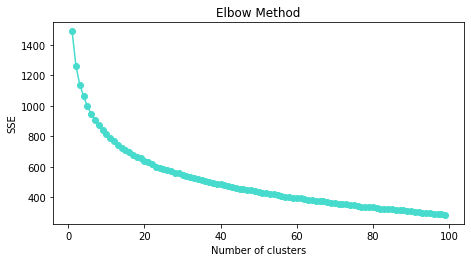

CPU times: user 7min 42s, sys: 6min 4s, total: 13min 47s
Wall time: 7min 19s


In [92]:
%%time
SSE = []
for i in range(1,100):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=50, random_state=42)
    kmeans.fit(node2vec_output)
    SSE.append(kmeans.inertia_)
plt.plot(range(1,100), SSE,"o-",color="#47DBCD")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.subplots_adjust(left=0.25, bottom=0.8, right=1.2, top=1.5)
plt.show()

## plot k-means clustering

In [93]:
n_clusters=kmeans.n_iter_

In [94]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=50, random_state=42)

In [95]:
kmeans.fit(node2vec_output)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=12, n_init=50, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

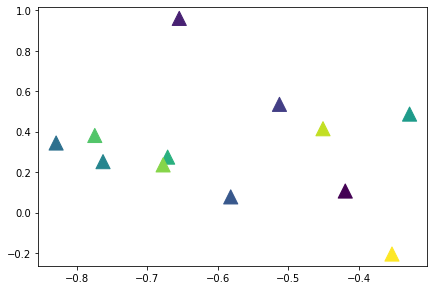

In [96]:
t = np.arange(n_clusters)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=200, c=t,marker="^")
plt.subplots_adjust(left=0.1, bottom=0.1, right=1, top=1)

In [97]:
subsample=[]
for i in range(kmeans.n_clusters):
  temp = []
  temp=node2vec_output.iloc[kmeans.labels_==i,:]
  subsample.append(temp)

In [98]:
for list in range(len(subsample)):
  print("Group",list+1)
  print(subsample[list])
  print("--------------------------------------------------------------")

Group 1
               0         1         2   ...        10        11        12
i712    -0.316004  0.096412  0.057411  ... -0.258166 -0.219993  0.396013
z91011  -0.375673  0.108014  0.035622  ... -0.311963 -0.281591  0.444286
z91018  -0.479282  0.048399  0.109698  ... -0.375803 -0.438254  0.626932
f1190   -0.378115  0.107304  0.149873  ... -0.316491 -0.326526  0.496876
t8383xa -0.353771  0.029830  0.075652  ... -0.238590 -0.293658  0.407575
...           ...       ...       ...  ...       ...       ...       ...
b009    -0.359220  0.140486  0.139076  ... -0.269510 -0.266727  0.424972
a414    -0.304050  0.030003  0.036535  ... -0.284032 -0.287612  0.435085
f4321   -0.357087  0.080699  0.090113  ... -0.240424 -0.230318  0.443794
f72     -0.634551  0.180543  0.043058  ... -0.435499 -0.332613  0.526848
e1042   -0.355281  0.307304  0.049246  ... -0.451315 -0.360015  0.483274

[972 rows x 13 columns]
--------------------------------------------------------------
Group 2
             0      

# T-SNE

In [99]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=10, init='random', n_iter=5000, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(32, 20))
    sns.scatterplot(
        x=x, y=y,
        hue= kmeans.labels_,
        palette=sns.color_palette("hls", len(set(kmeans.labels_))),
        legend="full",
        alpha=0.7,
        s=120
        ) 
    for i in range(len(x)):
      
      plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(3, 1),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    
        
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


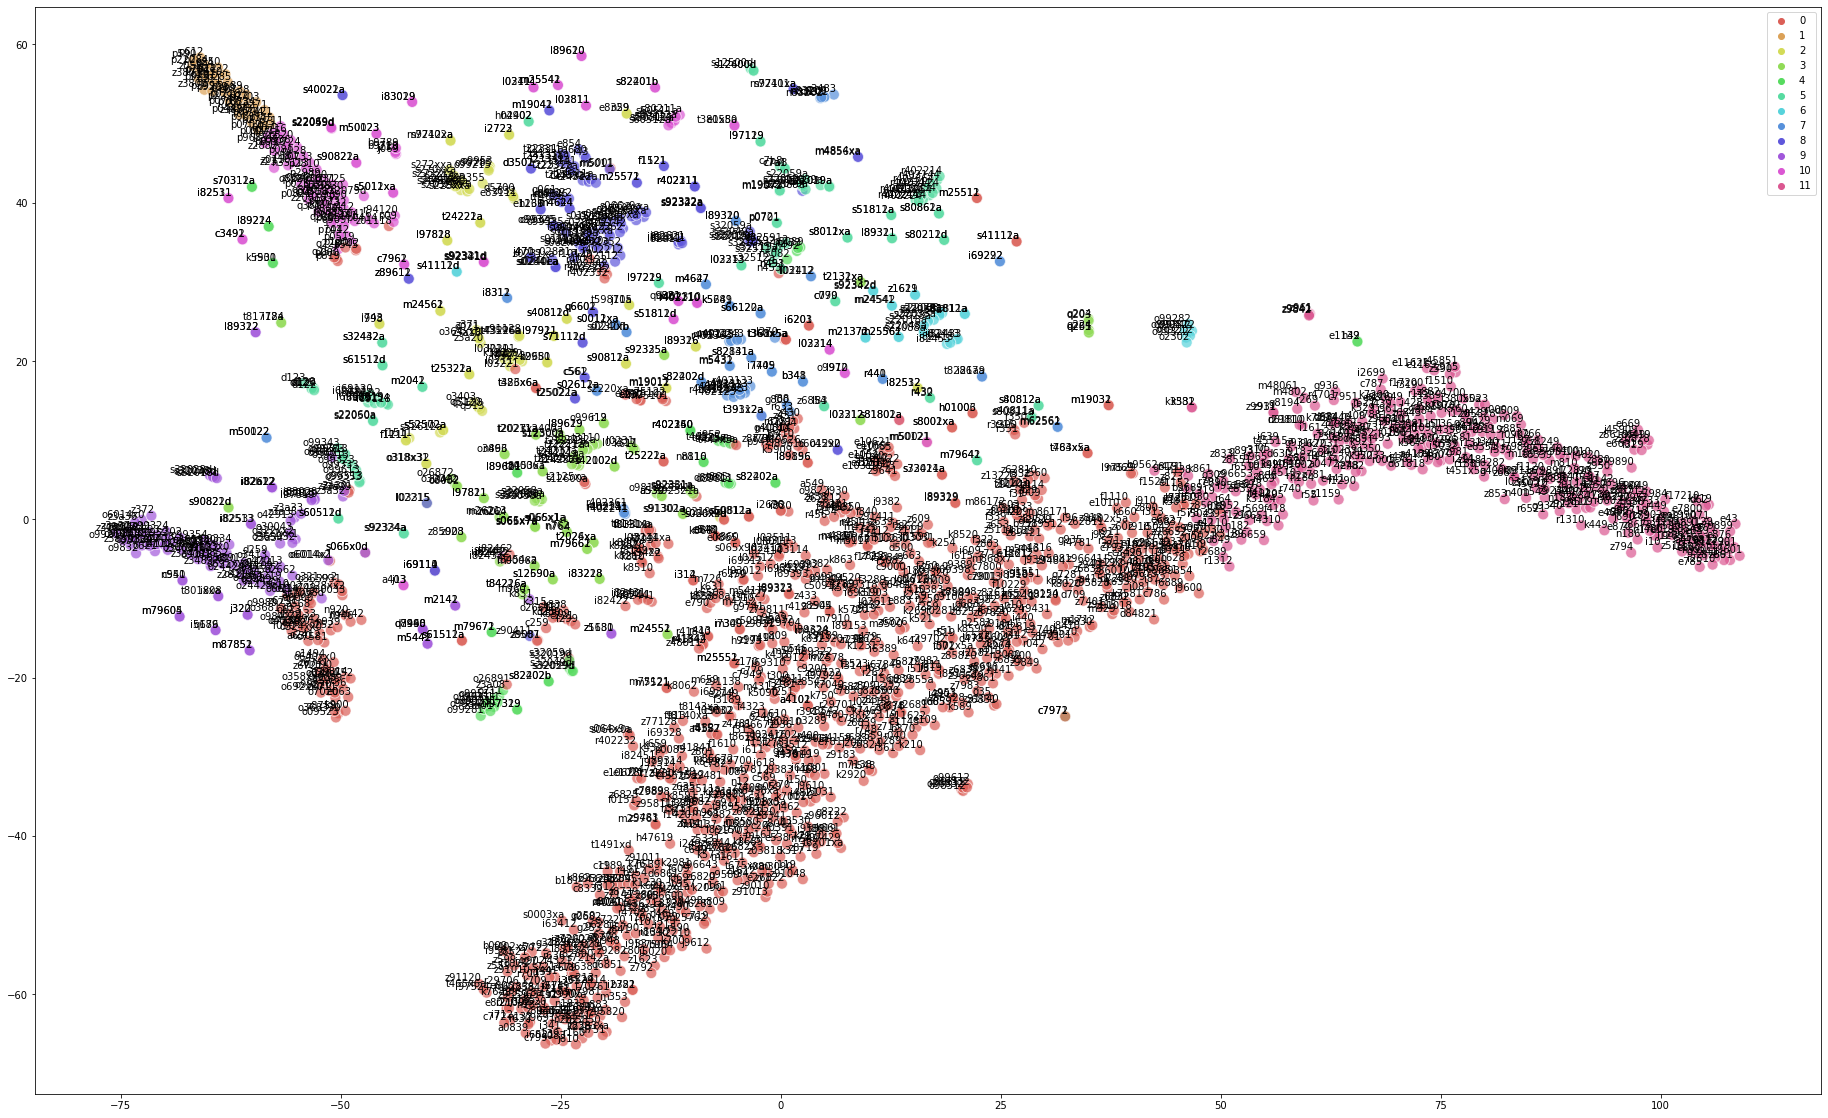

CPU times: user 2min 51s, sys: 1.39 s, total: 2min 52s
Wall time: 1min 32s


In [100]:
%%time
tsne_plot(model)